In [ ]:
# default_exp overlap.randomized

In [ ]:
#export
import numpy as np
from fisherman.utils import sym_from_triu, vector_basis, hamming_distance

from qiskit import QuantumCircuit
from qiskit.providers import Backend
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import random_unitary
from qiskit.circuit import ParameterExpression
from qiskit.opflow import ListOp, StateFn, PrimitiveOp, TensoredOp, ExpectationBase, CircuitSampler, Zero

from collections.abc import Iterable
from typing import Optional, Union, Dict, List

# Randomized measurements

> Functionalities to compute the overlap between two states through random measurements.

## Random unitary evolution

Performing random measurements on a state is equivalent to evolving it through random unitaries and, then, performing projective measurements on a state vector of a basis of choice. In this implementation, we take our reference state vector to be the $|0\rangle$ of the computational basis.

However, the first step is being able to randomly evolve states, for which we need to properly sample unitary operators from the Haar metric.

In [ ]:
#export
def random_unitary_circuits(
    n_rnd: int, 
    n_qubits: int, 
    d: Optional[int] = 2, 
    local: Optional[bool] = True
) -> ListOp:
    "Samples `n_rnd` unitary random circuits with acting on `n_qubits`."
    def _random_circuit(n_qubits): 
        if local: 
            return TensoredOp([PrimitiveOp(random_unitary(d)) for _ in range(n_qubits)])
        else:
            return PrimitiveOp(random_unitary(d**n_qubits))
    return ListOp([_random_circuit(n_qubits) for _ in range(n_rnd)])

`local` indicates whether the random unitaries act at a local (`local=True`) or global (`local=False`) level. Global unitaries are much more costly to implement both at a numerical and experimental level. In terms of simulation, they require the explicit computation of $N\times N$ matrices, where $N$ is the size of the Hilbert space. In contrast, the operator resulting from the combination of local unitaries is expressed as the lazy computation of their tensor product, which is a list of `n_qubits` elements of size $d\times d$, where `d` is the size of the local Hilbert space.  

In [ ]:
n_qubits = 2
loc = random_unitary_circuits(1, n_qubits)[0]
glob = random_unitary_circuits(1, n_qubits, local=False)[0]
print(loc)
print(glob)

TensoredOp([
  Operator([[ 0.07099579+0.32903812j,  0.75676771+0.56035358j],
            [ 0.94076065+0.04077892j, -0.26224586+0.21102985j]],
           input_dims=(2,), output_dims=(2,)),
  Operator([[-0.30514745-0.1707145j ,  0.93310157+0.08404199j],
            [ 0.91508156+0.20091623j,  0.34239631-0.07087433j]],
           input_dims=(2,), output_dims=(2,))
])
Operator([[-0.34752919+0.56203462j,  0.08680883-0.41629036j,
           -0.03508419+0.18996298j, -0.21437868+0.54702107j],
          [ 0.37249939-0.0753213j ,  0.02126428+0.10429014j,
           -0.22450534-0.66745055j, -0.3635745 +0.46493333j],
          [ 0.01154624-0.41187321j,  0.44426806-0.09316649j,
            0.65389342+0.00971268j,  0.18810724+0.40139479j],
          [-0.08891875-0.4911538j , -0.70610247-0.32125248j,
            0.11540848+0.16062449j, -0.2948111 +0.15180454j]],
         input_dims=(2, 2), output_dims=(2, 2))


In terms of actual execution on a quantum hardware, the performance of local unitaries is straightforward, whereas global unitaries must be decomposed into a series of local operations. 

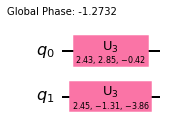

In [ ]:
loc.to_circuit_op().primitive.draw('mpl')

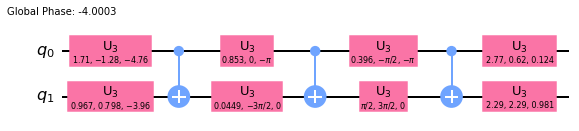

In [ ]:
glob.to_circuit_op().primitive.draw('mpl')

## Overlap through randomized measurements

In [ ]:
#export
def randomized_measurement_overlap(
    state0: Union[StateFn, QuantumCircuit], 
    state1: Optional[Union[StateFn, ListOp]] = None, 
    param_dict: Optional[Dict[ParameterExpression, List[float]]] = None,
    n_rnd: Optional[int] = None,
    local: Optional[bool] = True,
    expectation: Optional[ExpectationBase] = None, 
    backend: Optional[Union[Backend, QuantumInstance]] = None
) -> np.ndarray:
    """Overlap computation between states using randomized measurements."""
    
    if state1 is not None and param_dict is not None: 
        raise ValueError(
            "randomized_measurement_overlap only accepts one optional input "
            "either `state1` or `param_dict`."
        )
        
    if isinstance(state0, QuantumCircuit): 
        state0 = CircuitStateFn(state0)
        
    if param_dict is not None: 
        state = state0.bind_parameters(param_dict)
    elif state1 is not None: 
        state = ListOp([state0, *state1]) if isinstance(state1, ListOp) else ListOp([state0, state1]) 
    else: 
        state = ListOp([state0])

    n_qubits = state0.num_qubits
    n_rnd = 2**(6 + n_qubits//2) if n_rnd is None else n_rnd
    U = random_unitary_circuits(n_rnd, n_qubits, local=local)
    observable = (U @ state) if local else (~Zero @ U @ state)
    
    if expectation is not None: 
        observable = expectation.convert(observable)
        
    if backend is not None:
        observable = CircuitSampler(backend).convert(observable)
    
    overlap = _overlap_from_local(observable) if local else _overlap_from_global(observable)
    
    return overlap[0, 1:] if state1 is not None else overlap.squeeze()

def _overlap_from_global(observable):
    "Overlap computation from measurements obtained through global random unitaries."
    rnd_meas = np.abs(observable.eval())**2
    p = rnd_meas.mean(0)
    
    def _prefactor(counts):
        "Prefactor `N(N+1)` where `N` is the estimated Hilbert space size."
        n_experiments = counts.shape[1]
        pmat = np.broadcast_to(p, (n_experiments, n_experiments))
        N = 1/pmat # Estimated size of the Hilbert space
        triu = np.triu(np.ones(n_experiments))
        tril = np.where(triu==0, 1, 0)
        return (N + triu)*(N.T + tril)
    
    product_expectation = (rnd_meas.T @ rnd_meas)/rnd_meas.shape[0]
    return _prefactor(rnd_meas)*product_expectation - 1

def _overlap_from_local(observable, transp_sv=True):
    "Overlap computation from measurements obtained through local random unitaries."
    statevectors = _statevector_to_matrix(observable.eval())
    if transp_sv: 
        statevectors = statevectors.transpose(1, 0, 2)
    rnd_meas = np.abs(statevectors)**2
    n_states, n_rnd, _ = rnd_meas.shape
    
    def _prefactor(n, d=2):
        "Prefacotr ::math:: $(-d)^{-D(s, s')}$. See Eq. (4) in [ref]"
        v = vector_basis(n)
        dists = sym_from_triu([hamming_distance(v_i, v_j) 
                               for i, v_i in enumerate(v) for v_j in v[i:]], d**n)
        return (-d)**(-dists)
    
    pref = _prefactor(observable.num_qubits)
    N = 1/rnd_meas.mean()
    overlaps = [np.sum(N*pref*(m_i.T @ m_j)/n_rnd) 
                for i, m_i in enumerate(rnd_meas) for m_j in rnd_meas[i:]]
    return sym_from_triu(overlaps, n_states)

def _statevector_to_matrix(v):
    list_of_matrices = list(map(lambda x: list(map(lambda y: y.to_matrix().squeeze(), x)), v))
    return np.array(list_of_matrices)

In [ ]:
#hide
from qiskit import BasicAer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.opflow import CircuitStateFn, PauliExpectation

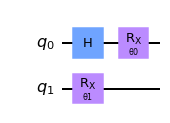

In [ ]:
theta0, theta1 = Parameter('θ0'), Parameter('θ1')
qc = QuantumCircuit(2)
qc.h(0)
qc.rx(theta0, 0)
qc.rx(theta1, 1)
qc.draw('mpl')

In [ ]:
state = CircuitStateFn(qc)
expectation = PauliExpectation()
backend = BasicAer.get_backend('qasm_simulator')
qi = QuantumInstance(backend, shots=1000)

In [ ]:
param_dict = {theta0: [0, 0.1, 0.1], 
              theta1: [0, 0.1, 1.5]}

In [ ]:
overlap = randomized_measurement_overlap(state, param_dict=param_dict, n_rnd=500, 
                                         local=False, expectation=expectation, backend=qi)
overlap

array([[0.95660219, 0.94857493, 0.46670327],
       [0.94857493, 0.95362864, 0.51531025],
       [0.46670327, 0.51531025, 1.00551041]])

In [ ]:
overlap = randomized_measurement_overlap(state, param_dict=param_dict, n_rnd=500,
                                         local=True, expectation=expectation, backend=qi)
overlap

array([[0.96025352, 0.95692673, 0.54417865],
       [0.95692673, 0.96440688, 0.5944077 ],
       [0.54417865, 0.5944077 , 0.99312741]])

In [ ]:
state0 = state.bind_parameters({theta0: 0., theta1: 0.5})
state1 = state.bind_parameters({theta0: [0.2, 0.5], theta1: [1.5, 0.5]})

overlap = randomized_measurement_overlap(state0, state1, n_rnd=200)
overlap

array([0.76451921, 0.97574972])

In [ ]:
purity = randomized_measurement_overlap(state0)
purity

## Overlap across backends 

In [ ]:
#export
def device_independent_overlap(state0, backends, state1=None, n_rnd=None, local=True):
    "Computes overlap between states through randomized measurements using different backends."
    
    n_qubits = state0.num_qubits
    n_rnd = 2**(6 + n_qubits//2) if n_rnd is None else n_rnd
    U = random_unitary_circuits(n_rnd, n_qubits, local=local)
    
    if not isinstance(backends, Iterable): 
        backends = [backends]
    n_backends = len(backends)

    if state1 is None:
        if n_backends > 1:
            states = [state0]*len(backends)
        else:
            raise ValueError(
                "If `state1` is not provided, the number of backeds must be larger" 
                f" than one, not {len(backends)}."
            )
    else:
        if not isinstance(state1, Iterable):
            state1 = [state1]
        states = [state0, *state1]
        if n_backends == 1:
            from qiskit.providers.aer import StatevectorSimulator
            backends = [StatevectorSimulator()] + backends*len(state1)
        elif n_backends == 2:
            backends = [backends[0]] + [backends[1]]*len(state1)
        elif n_backends == len(state1):
            from qiskit.providers.aer import StatevectorSimulator
            backends = [StatevectorSimulator()] + backends
        elif n_backends == len(states):
            pass
        else:
            raise ValueError(
                f"Number of backends must be either 1, 2, len(state1) = {len(state1)} "
                f"or len(state1) + 1 = {len(state1) + 1}, not {n_backends}."
            )          
            
    observable = ListOp([CircuitSampler(qi).convert((U @ s) if local else (~Zero @ U @ s)) 
                  for qi, s in zip(backends, states)])
            
    overlap = (_overlap_from_local(observable, transp_sv=False) if local 
               else _overlap_from_global(observable))
    
    return overlap
    
    return overlap[0] if state1 is not None else overlap.squeeze()